In [1]:
from clique_benchmark import Trials, CompileType
from graph_database import Graphs, Graph
import matplotlib.pyplot as plt
import numpy as np
graph_db = Graphs()
trial_db = Trials()

In [2]:
# run this cell to load the job results for all trials that are waiting pending job results
await trial_db.load_results()

Found 2328 jobs with missing results
Processing batch 1 of 117
Error fetching results for job d0ecqb5ehmr0008fvy3g: 'Unable to retrieve job result. Error code 9703; Internal error -- https://ibm.biz/error_codes#9703'
Error fetching results for job d0ecqadvpqf00083y70g: 'Unable to retrieve job result. Error code 9699; Internal Error -- https://ibm.biz/error_codes#9699'
Processing batch 2 of 117
Processing batch 3 of 117
Processing batch 4 of 117
Processing batch 5 of 117
Processing batch 6 of 117
Processing batch 7 of 117
Processing batch 8 of 117
Processing batch 9 of 117
Processing batch 10 of 117
Processing batch 11 of 117
Processing batch 12 of 117
Processing batch 13 of 117
Processing batch 14 of 117
Processing batch 15 of 117
Processing batch 16 of 117
Processing batch 17 of 117
Processing batch 18 of 117
Processing batch 19 of 117
Processing batch 20 of 117
Processing batch 21 of 117
Processing batch 22 of 117
Processing batch 23 of 117
Processing batch 24 of 117
Processing batch

In [3]:
for grover_iterations in range(1, 6):
    print(f"Grover iterations: {grover_iterations}")
    for trial in trial_db.get(grover_iterations=grover_iterations):
        print(f"Trial {trial.trial_id} with graph: {trial.graph}")
        print(sorted(trial.counts.items(), key=lambda t: t[1], reverse=True))
        print(sorted(trial.simulation_counts.items(), key=lambda t: t[1], reverse=True))
        print(trial.success_rate)
        print(trial.simulation_success_rate)
        print(trial.expected_success_rate)
        print("")

Grover iterations: 1
Trial 1 with graph: 001
[('010', 148), ('111', 144), ('110', 143), ('000', 136), ('011', 121), ('001', 107), ('100', 105), ('101', 96)]
[('110', 474), ('111', 96), ('010', 82), ('001', 77), ('101', 71), ('100', 71), ('000', 67), ('011', 62)]
0.143
0.474
0.7812500000000001

Trial 3 with graph: 100
[('101', 159), ('111', 139), ('011', 135), ('010', 133), ('001', 120), ('110', 116), ('100', 106), ('000', 92)]
[('011', 485), ('000', 80), ('100', 78), ('110', 77), ('010', 75), ('001', 74), ('111', 66), ('101', 65)]
0.135
0.485
0.7812500000000001

Trial 5 with graph: 011
[('011', 277), ('010', 147), ('100', 139), ('000', 112), ('001', 107), ('110', 87), ('101', 68), ('111', 63)]
[('110', 511), ('101', 489)]
0.155
1.0
1.0

Trial 6 with graph: 010
[('010', 150), ('111', 138), ('000', 137), ('110', 135), ('101', 119), ('011', 111), ('001', 106), ('100', 104)]
[('101', 469), ('100', 82), ('000', 81), ('111', 79), ('110', 77), ('011', 74), ('001', 71), ('010', 67)]
0.119
0.46

In [4]:
def get_probability_data(trial_db, compile_type=None):
    n_data = []
    grover_iterations_data = []
    probability_data = []

    for n in range(2, 21):
        for grover_iterations in range(1, 6):
            print(f"(n, grover_iterations) = ({n}, {grover_iterations})")
            trials = trial_db.get(n=n, grover_iterations=grover_iterations, compile_type=compile_type)

            if len(trials) == 0:
                print(f"Warning: no results for {n} variables, complexity {grover_iterations}; skipping")
                continue

            success_rates = np.zeros(len(trials))
            expected_success_rates = np.zeros(len(trials))

            for i, trial in enumerate(trials):
                success_rates[i] = trial.success_rate
                expected_success_rates[i] = trial.expected_success_rate
            
            n_data.append(n)
            grover_iterations_data.append(grover_iterations)
            probability_data.append(np.mean(success_rates / expected_success_rates))
            print(f"Mean success rate over expected: {probability_data[-1]}")
    
    return n_data, grover_iterations_data, probability_data

def plot_probability_data(n_data, grover_iterations_data, probability_data, title, filepath=None):
    plt.figure(figsize=(20, 10))
    plt.scatter(n_data, grover_iterations_data, c=probability_data, cmap='RdYlGn', edgecolors='black', alpha=0.75, s=450)
    plt.xticks(np.arange(min(n_data), max(n_data) + 1, 1))
    plt.yticks(np.arange(min(grover_iterations_data), max(grover_iterations_data) + 1, 1))

    plt.xlabel('Verticies Count')
    plt.ylabel('Grover Iterations')
    plt.title(title)
    cbar = plt.colorbar()
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
n_data, grover_iterations_data, probability_data = get_probability_data(trial_db, compile_type=CompileType.CLASSICAL_FUNCTION)

(n, grover_iterations) = (2, 1)
(n, grover_iterations) = (2, 2)
(n, grover_iterations) = (2, 3)
(n, grover_iterations) = (2, 4)
(n, grover_iterations) = (2, 5)
(n, grover_iterations) = (3, 1)
Mean success rate over expected: 0.3145266666666667
(n, grover_iterations) = (3, 2)
Mean success rate over expected: 0.13505234159779614
(n, grover_iterations) = (3, 3)
(n, grover_iterations) = (3, 4)
(n, grover_iterations) = (3, 5)
(n, grover_iterations) = (4, 1)
Mean success rate over expected: 0.2589380081752842
(n, grover_iterations) = (4, 2)
Mean success rate over expected: 0.11800978290885696
(n, grover_iterations) = (4, 3)
Mean success rate over expected: 0.06328111194002212
(n, grover_iterations) = (4, 4)
(n, grover_iterations) = (4, 5)
(n, grover_iterations) = (5, 1)
Mean success rate over expected: 0.2298588708175571
(n, grover_iterations) = (5, 2)
Mean success rate over expected: 0.09513603367675454
(n, grover_iterations) = (5, 3)
Mean success rate over expected: 0.05788676830916716
(n,

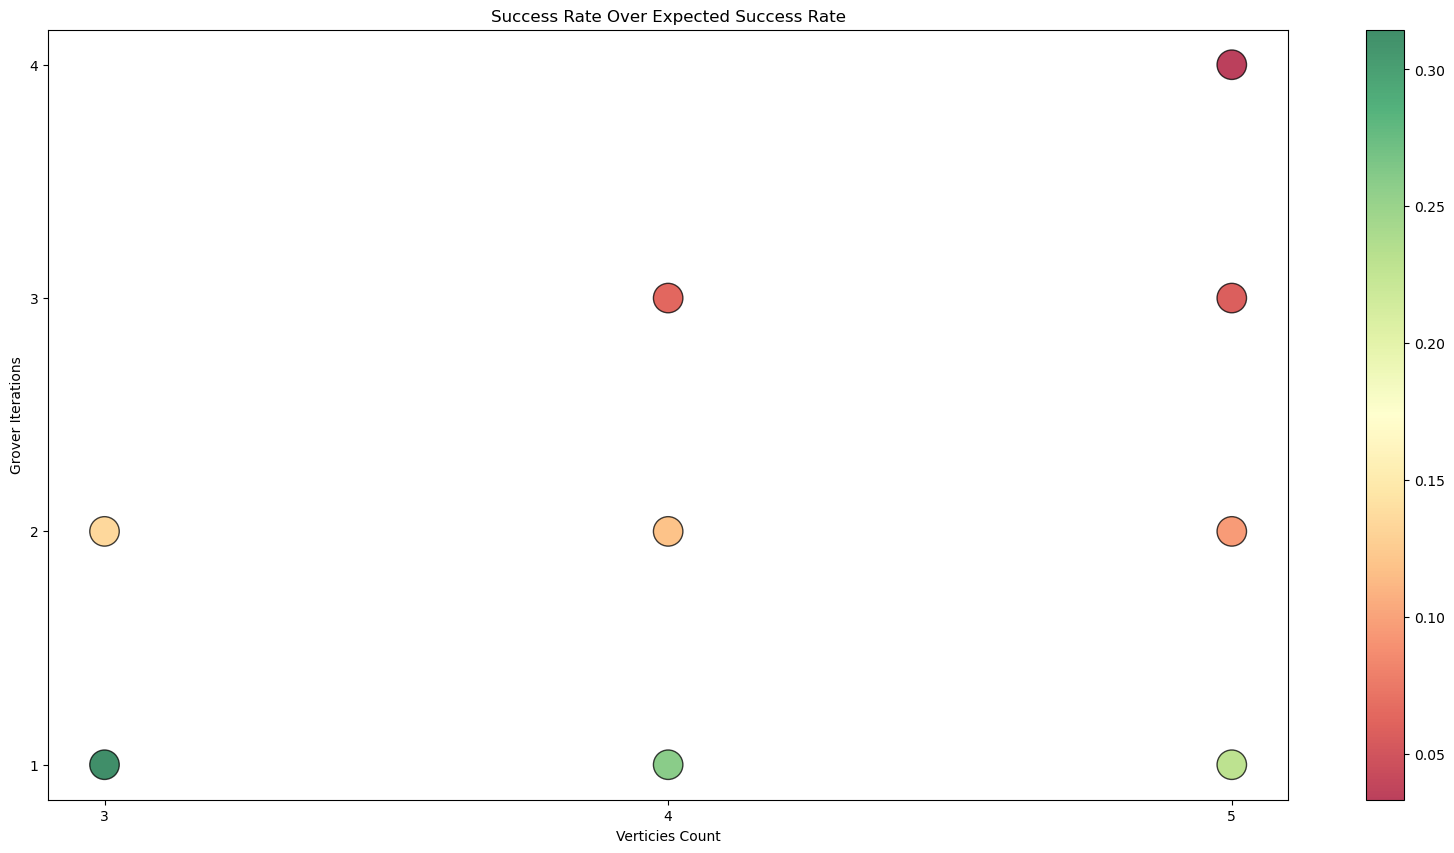

In [6]:
plot_probability_data(n_data, grover_iterations_data, probability_data, "Success Rate Over Expected Success Rate (Classical Function)", filepath="classical_function_mean_success_rate_over_expected.png")

(n, grover_iterations) = (2, 1)
(n, grover_iterations) = (2, 2)
(n, grover_iterations) = (2, 3)
(n, grover_iterations) = (2, 4)
(n, grover_iterations) = (2, 5)
(n, grover_iterations) = (3, 1)
Mean success rate over expected: 0.21926
(n, grover_iterations) = (3, 2)
Mean success rate over expected: 0.1435151515151515
(n, grover_iterations) = (3, 3)
(n, grover_iterations) = (3, 4)
(n, grover_iterations) = (3, 5)
(n, grover_iterations) = (4, 1)
Mean success rate over expected: 0.25319940750583314
(n, grover_iterations) = (4, 2)
Mean success rate over expected: 0.11768841089444057
(n, grover_iterations) = (4, 3)
Mean success rate over expected: 0.06848229922276367
(n, grover_iterations) = (4, 4)
(n, grover_iterations) = (4, 5)
(n, grover_iterations) = (5, 1)
Mean success rate over expected: 0.22240998810280338
(n, grover_iterations) = (5, 2)
Mean success rate over expected: 0.10314139818340896
(n, grover_iterations) = (5, 3)
Mean success rate over expected: 0.057713366655688325
(n, grover_i

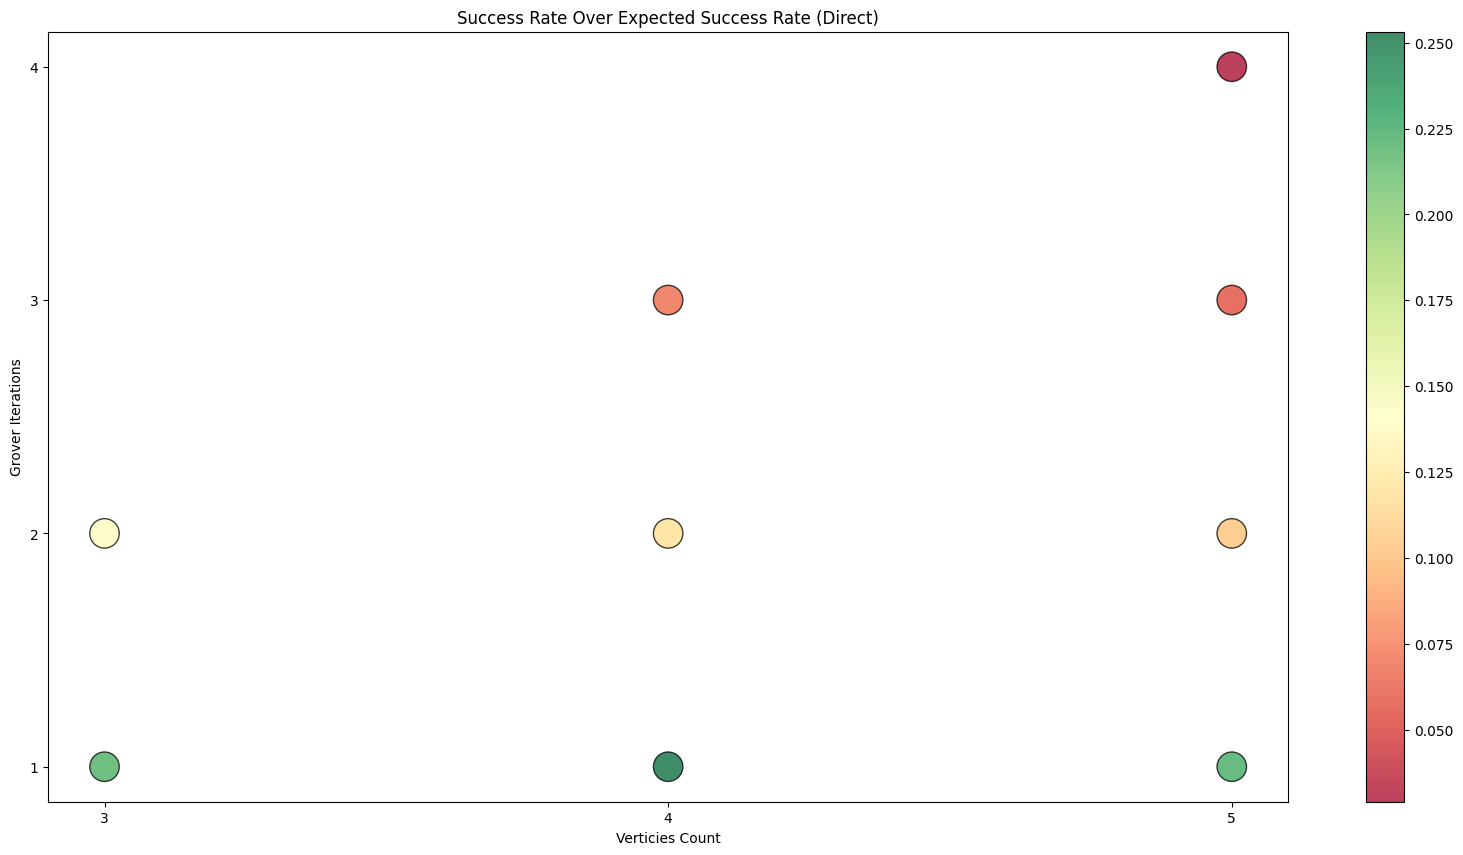

In [5]:
n_data, grover_iterations_data, probability_data = get_probability_data(trial_db, compile_type=CompileType.DIRECT)
plot_probability_data(n_data, grover_iterations_data, probability_data, "Success Rate Over Expected Success Rate (Direct)", filepath="direct_mean_success_rate_over_expected.png")